# Transdimensional nonequilibrium free energy calculations for molecular design

### ADAPTIVE SAMPLING

### P. B. Grinway, H. E Bruce Macdonald, A. Rizzi, Z. Tan, J. M. Behr, I. Zhang, B. Allen, W. Sherman, J. D. Chodera

### FreeSolv dataset

Adaptively selecting atom mappings using a Normal-Normal inverse gamma Bayesian Bandit

Sampling free energies, which follow a normal distribuition of unknown $\mu$ and $\sigma$

Prior Normal inverse gamma F($\nu$=0,$\lambda$=1,$\alpha$=2,$\beta$=1), where $\nu$ is the mean.


Prioritizing sampling from atom mappings with the small variance.

In [1]:
from drugbandit import bandit, pull, choose
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import random
import itertools
from scipy.special import erf

import seaborn as sns
# from random import randint

%matplotlib inline

Loading the example ligands

In [2]:
ligands = []
# import drugbandit
lig_id = 0
with open('set_of_eight.smiles','r') as f:
    index = 0
    for line in f:
        if line[0] != '#':
            details = line.split(';')
            ligands.append(bandit.Node(details[2], float(details[3]), float(details[4]),lig_id))
            lig_id += 1

index = 0
edges = []

lig_ids = [lig.index for lig in ligands]


#TODO this currently initiates edges with 3 mappings of different deviations
for lig_a, lig_b in itertools.combinations(ligands,2):  # generating all edges
    edges.append(bandit.Edges(lig_a,lig_b))
    index+=1
    
# edges = [bandit.Edges(lig_a,lig_a)]

In [3]:
#########################
# simulation parameters #
#########################
steps_per_edge = 10000
print_freq = 5000
boltzmann_temp = 1.

### ADAPTIVE


#### TODO: increase preference for smaller variance
Sampling mapping inversely proportional to the bandit's standard deviation

Step 0


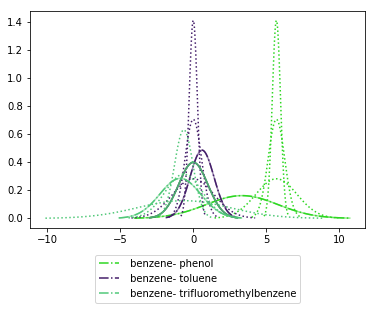

Step 5000


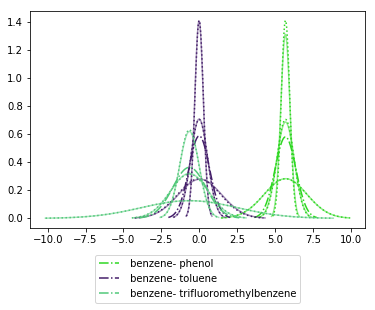

Step 10000


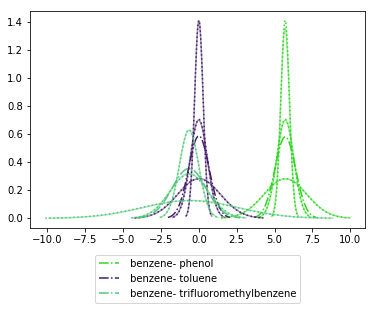

In [4]:
adaptive_errors = []
adaptive_counts = []

for step in range(0,steps_per_edge+1):
    for edge in edges:
        pick_bandit = choose.boltzmann_ranking(edge.bandits,boltzmann_temp)
        print
#         print('real',pick_bandit.name)
        reward = pull.Pull(pick_bandit)
        pick_bandit.update(reward)
        edge.update()
        
    if step % print_freq == 0:
        print('Step {}'.format(step))
        ax = plt.subplot(1, 1, 1)
        for edge in edges[0:3]: # only plotting a subset of bandits to see how they're doing
            edge.plot()
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
        plt.show()

adaptive_errors = []
adaptive_steps = []

for edge in edges:
    for band in edge.bandits:
        adaptive_errors.append(band.error)
        adaptive_steps.append(band.nsteps)

adaptive_sigma = [edge.sigma for edge in edges]


### VANILLA

Step 0


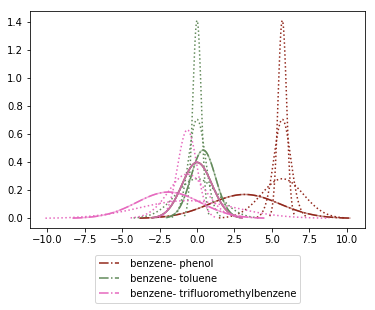

Step 5000


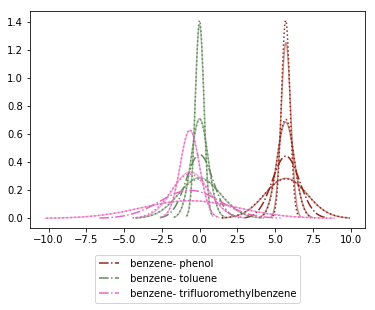

Step 10000


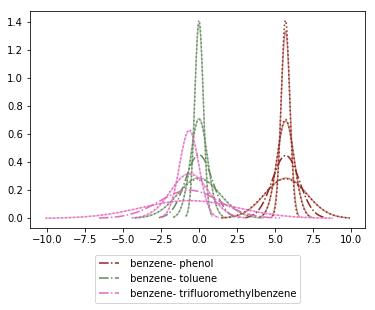

In [5]:
# resets the bandits
edges = []
for lig_a, lig_b in itertools.combinations(ligands,2): 
    edges.append(bandit.Edges(lig_a,lig_b))
    index+=1
    
for step in range(0,steps_per_edge+1):
    for edge in edges:
        pick_bandit = np.random.choice(edge.bandits) # mappings chosen at random
        reward = pull.Pull(pick_bandit)
        pick_bandit.update(reward)
        edge.update()
        
    if step % print_freq == 0:
        print('Step {}'.format(step))
        ax = plt.subplot(1, 1, 1)
        for edge in edges[0:3]:
            edge.plot()
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
        plt.show()

vanilla_errors = []
vanilla_steps = []

for edge in edges:
    for band in edge.bandits:
        vanilla_errors.append(band.error)
        vanilla_steps.append(band.nsteps)
vanilla_sigma = [edge.sigma for edge in edges]

/Users/brucemah/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


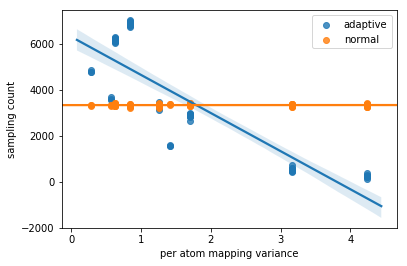

In [6]:
sns.regplot(x=adaptive_errors,y=adaptive_steps,label='adaptive')
sns.regplot(x=vanilla_errors,y=vanilla_steps,label='normal')
plt.xlabel('per atom mapping variance')
plt.ylabel('sampling count')
plt.legend()

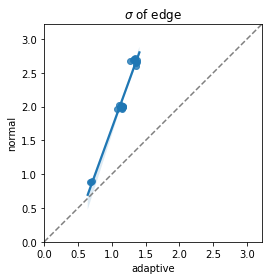

In [7]:
unity = [0,max(adaptive_sigma+vanilla_sigma)+0.5]
fig = plt.figure()
ax = fig.add_subplot(111,aspect=1)
# plt.
sns.regplot(x=adaptive_sigma,y=vanilla_sigma,label='normal')
plt.xlim(unity)
plt.ylim(unity)
plt.title('$\sigma$ of edge')
plt.xlabel('adaptive')
plt.ylabel('normal')
plt.plot(unity,unity,'--',color='grey')

### Mcl-1 dataset

Adaptively selecting atom mappings using a Bernoulli-Beta Bayesian Bandit

Sampling likelihood that lig X is higher affinity than reference

Prior Beta($\alpha$=1,$\beta$=1).


Prioritizing sampling of ligands with highest affinity.

In [12]:
# Loading the example ligands
ligands = []
# import drugbandit
lig_id = 0
with open('set_of_eight.smiles','r') as f:
    index = 0
    for line in f:
        if line[0] != '#':
            details = line.split(';')
            ligands.append(bandit.Node(details[2], float(details[3]), float(details[4]),lig_id))
            lig_id += 1

# ligands = ligands[0:3]         
baseline_ligand = 5 # arbitrary choice of ligand

edges = []

#TODO this currently initiates edges with 3 mappings of different deviations
for lig_a, lig_b in itertools.combinations(ligands,2):  # generating all edges
    edges.append(bandit.Edges(lig_a,lig_b))
    index+=1

n_steps = 3 # include paths between ligands that involve up to n_steps edges
    
for ligand in ligands:
    ligand.find_all_paths(baseline_ligand,edges,n_steps)



In [13]:
#########################
# simulation parameters #
#########################
steps_per_ligand = 1000
print_freq = 200
boltzmann_temp = 1. # larger value = more random

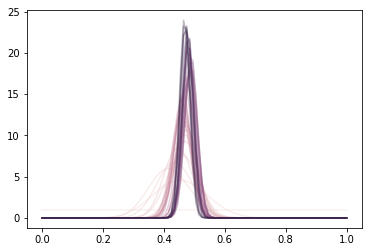

In [14]:
steps = steps_per_ligand*len(ligands)
colours = sns.cubehelix_palette(steps+1)

alpha = []
beta = []

# testing each atom mapping once as a starting point
for edge in edges:
    for band in edge.bandits:
        reward = pull.Pull(band)
        band.update(reward)

lig_ids = [ligand.index for ligand in ligands]
# edges = [ligand]
for step in range(0,steps+1):
    pick_ligand = choose.boltzmann(ligands,1.)
    ## with a ligand selected, now pick a random bandit attached to the node
    ## and update the understanding of the nodes free energy based on it
    # random edge of ligand
    pick_edge = np.random.choice([edge for edge in edges if pick_ligand.index in edge.indexes]) 
    # random bandit of edge
    pick_bandit = np.random.choice(pick_edge.bandits)
    map_reward = pull.Pull(pick_bandit)
    pick_bandit.update(map_reward)
    
    pick_edge.update()
    reward = pick_ligand.pull(edges)
    pick_ligand.update(reward)
    
    if step % print_freq == 0:    
        alpha.append(ligands[0].a)
        beta.append(ligands[0].b)
        ligands[0].plot(colours[step])

plt.show()

-0.9
mean 0.46760259179265656


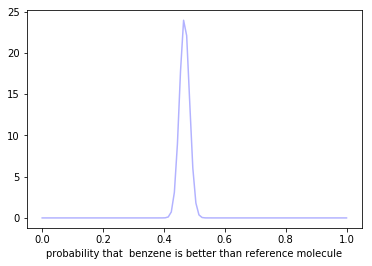

-6.6
mean 0.9341359773371105


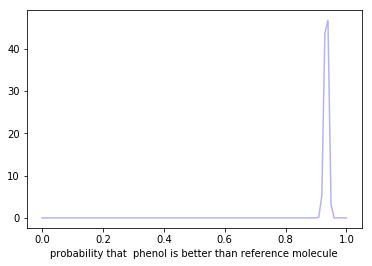

-0.9
mean 0.47729918509895225


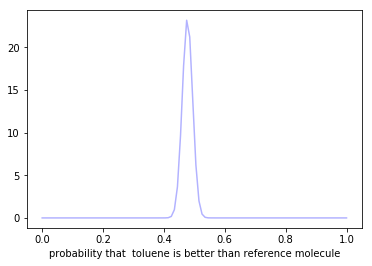

-0.25
mean 0.4344528710725894


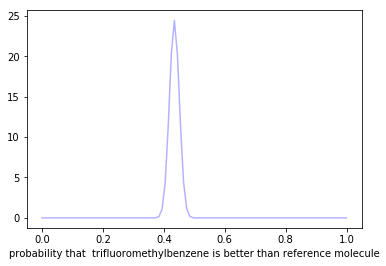

1.07
mean 0.2975609756097561


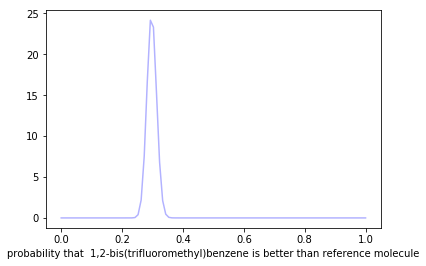

-1.12
mean 0.49067599067599066


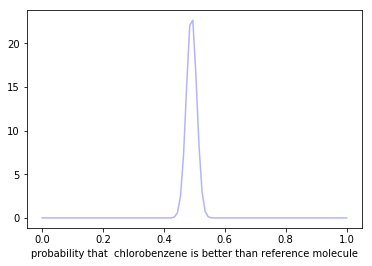

-4.55
mean 0.8020924149956408


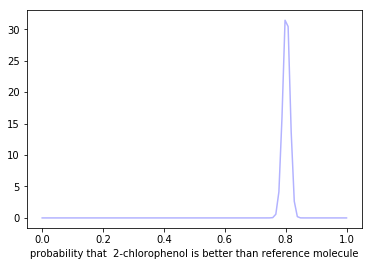

-2.55
mean 0.6501865671641791


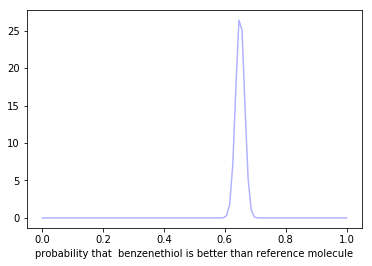

In [15]:
for x in ligands:
    print(x.fe)
    print('mean',(x.a)/(x.a+x.b))
    x.plot()
    plt.xlabel('probability that {} is better than reference molecule'.format(x.name))
    plt.show()

Text(0, 0.5, 'number of steps')

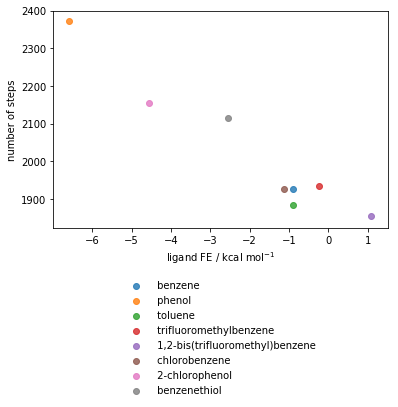

In [17]:
ligand_sampling = [0. for _ in ligands]
for edge in edges:
    edge_steps = np.sum([x.nsteps for x in edge.bandits])
    ligand_sampling[edge.indexes[0]] += edge_steps
    ligand_sampling[edge.indexes[1]] += edge_steps   

ligand_fes = [ligand.fe for ligand in ligands]


labels = [ligand.name for ligand in ligands]

for i,ligand in enumerate(ligands):
    plt.scatter(ligand.fe, ligand_sampling[i],label=ligand.name,
               alpha=0.8)

legend = plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
frame = legend.get_frame()
frame.set_color('white')
plt.xlabel('ligand FE / kcal mol$^{-1}$')
plt.ylabel('number of steps')

### PBAR

Adapt the above code to store the sampled states in the BB and extract the free energies 